In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.table import Table
import numpy as np
import scipy.optimize as op
import os
import sys
sys.path.append(f'{os.environ["HOME"]}/Projects/planckClusters/catalogs')
from load_catalogs import load_PSZcatalog
from tqdm import tqdm_notebook
                
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

In [2]:
from concurrent.futures import ThreadPoolExecutor, as_completed

def parallel_process(array, function, n_jobs=None, use_kwargs=False, front_num=0):
    """
        A parallel version of the map function with a progress bar. 

        Args:
            array (array-like): An array to iterate over.
            function (function): A python function to apply to the elements of array
            n_jobs (int, default=16): The number of cores to use
            use_kwargs (boolean, default=False): Whether to consider the elements of array as dictionaries of 
                keyword arguments to function 
            front_num (int, default=3): The number of iterations to run serially before kicking off the 
                parallel job. This can be useful for catching bugs
        Returns:
            [function(array[0]), function(array[1]), ...]
    """
    #We run the first few iterations serially to catch bugs
    if front_num > 0:
        front = [function(**a) if use_kwargs else function(a) for a in array[:front_num]]
    #If we set n_jobs to 1, just run a list comprehension. This is useful for benchmarking and debugging.
    if n_jobs==1:
        [function(**a) if use_kwargs else function(a) for a in tqdm_notebook(array[front_num:])]
        return 
    #Assemble the workers
    with ThreadPoolExecutor(max_workers=n_jobs) as pool:
        #Pass the elements of array into function
        if use_kwargs:
            futures = [pool.submit(function, **a) for a in array[front_num:]]
        else:
            futures = [pool.submit(function, a) for a in array[front_num:]]
        kwargs = {
            'total': len(futures),
            'unit': 'it',
            'unit_scale': False,
            'leave': True
        }
        #Print out the progress as tasks complete
        for f in tqdm_notebook(as_completed(futures), **kwargs):
            pass

In [3]:
def beta_model(So, r, rc, beta):
    ''' Beta model with 3 parameters. 
    So -- normalization
    rc -- core radius
    beta -- powerlaw slope

    '''
    
    return So * ( 1.0 + (r / rc)**2)**(-3.0 * beta + 0.5)

In [4]:
def chi2(model, y, y_err):
    '''Chi error. We are going to square this to make it the chi2 error.'''
    return np.sum(((model - y) / y_err)**2)

In [14]:
def like(theta, x, y, yerr):
    So, rc, beta, bg = theta
    model = beta_model(So, x, rc, beta) + bg
    return chi2(model, y, yerr)

def prior(theta):
    So, rc, beta, bg = theta
    if So < 0:
        return np.inf
    elif rc < 0:
        return np.inf
    elif beta < 0 or beta > 3: 
        return np.inf
    elif bg < 0:
        return np.inf
    else:
        return 0.0

def prob(theta, x, y, yerr):
    lp = prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return -lp - like(theta, x, y, yerr)

In [6]:
def fit_profile(name, outpath):
    
    # swift pixelscale in degrees
    pixsc =  6.548089E-04 * 3600
    
    if os.path.isfile(f'{outpath}/{name}/{name}_vtp.detect'):
        srcs = f'{outpath}/{name}/{name}_vtp.detect'
        # now we need to read the individual detections
        detects = Table.read(srcs, hdu=1)
    else:
        return
    
    # we are going to fit profiles to the top 3 biggest 
    detects.sort(['SRC_AREA'], reverse=True)
    
    # loop over the sources -- only the first 3
    for i in detects['COMPONENT'][:3]:
        
        if os.path.isfile(f'{outpath}/{name}/{name}_vtp_{i-1}.radprof'):
            data = Table.read(f'{outpath}/{name}/{name}_vtp_{i-1}.radprof', format='ascii', header_start=2)
        else:
            continue
            
        # x-axis, in arcminutes
        x = (data['r1'] + data['r2'])/ 2. / 60. * pixsc
        
        # this is the parameter fitting
        nll = lambda *args: prob(*args)
        result = op.minimize(nll, [0.001, 1, 1, 0.001], args=(x, data['sb'], data['sb_err']))
        
        
        # plot the result
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6.5, 5))
        # data
        ax.errorbar(x, data['sb'], yerr=data['sb_err'], fmt='o', label='data')
        ylims = ax.get_ylim()
        
        #fit
        So, rc, beta, bg = result['x']
        ax.plot(x, beta_model(So, x, rc, beta) + bg, label=r'$\beta$ + bg')
        ax.plot(x, beta_model(So, x, rc, beta), label=r'$\beta$')
        
        # rc and bg lines
        ax.axhline(bg, label='bg', zorder=0, lw=1)
        ax.text(rc + 0.1, 2e-5, f"rc = {rc:.2f}'", rotation='vertical', ha='left')
        ax.axvline(rc, zorder=0, lw=1)
        
        ax.semilogy()

        if ylims[0] < 1e-5:
            ax.set_ylim(1e-5, ylims[1])
        else:
            ax.set_ylim(ylims)
        ax.set_xlabel('Radius [arcmin]')
        ax.set_ylabel('Flux [cnts/s]')
        ax.legend(loc='upper right')
        
        fig.savefig(f'{outpath}/{name}/{name}_radproffit_{i-1}.png', bbox='tight', dpi=180)
        plt.close()
        

In [7]:
# get file data
data = load_PSZcatalog()
data = data.sort_index(axis=1)

outpath = './data_full'

arr = [{'name':n.replace(' ', '_'), 'outpath':outpath} for n in data['NAME']]
#parallel_process(arr, fit_profile, use_kwargs=True, n_jobs=1)

In [8]:
d = Table.read('./data_full/PSZ2_G018.92-33.64/PSZ2_G018.92-33.64_vtp_0.radprof', format='ascii', header_start=2)
#d = Table.read('./data_full/PSZ1_G083.35+76.41/PSZ1_G083.35+76.41_vtp_7.radprof', format='ascii', header_start=2)
d = Table.read('./data_full/PSZ1_G057.42/PSZ2_G018.92-33.64_vtp_0.radprof', format='ascii', header_start=2)


In [9]:
# swift pixelscale in degrees
pixsc =  6.548089E-04 * 3600
x = (d['r1'] + d['r2'])/ 2. / 60. * pixsc
nll = lambda *args: prob(*args)
result = op.minimize(nll, [0.001, 1, 1, 0.001], args=(x, d['sb'], d['sb_err']))

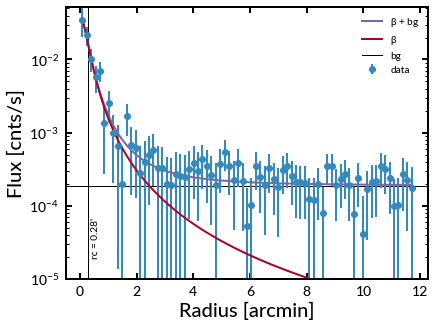

In [10]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6.5, 5))
# data
ax.errorbar(x, d['sb'], yerr=d['sb_err'], fmt='o', label='data')

ylims = ax.get_ylim()

#fit
So, rc, beta, bg = result['x']
ax.plot(x, beta_model(So, x, rc, beta) + bg, label=r'$\beta$ + bg')
ax.plot(x, beta_model(So, x, rc, beta), label=r'$\beta$')

ax.axhline(bg, label='bg', zorder=0, lw=1)

ax.text(rc + 0.1, 2e-5, f"rc = {rc:.2f}'", rotation='vertical', ha='left')
ax.axvline(rc, zorder=0, lw=1)
ax.semilogy()

if ylims[0] < 1e-5:
    ax.set_ylim(1e-5, ylims[1])
else:
    ax.set_ylim(ylims)
ax.set_xlabel('Radius [arcmin]')
ax.set_ylabel('Flux [cnts/s]')
ax.legend(loc='upper right')

In [11]:
result

      fun: 29.182691136377375
 hess_inv: array([[ 2.72636420e-05, -1.99615056e-04, -1.99591365e-04,
        -4.64299466e-08],
       [-1.99615056e-04,  4.38691556e-03,  4.38680147e-03,
         8.53705098e-07],
       [-1.99591365e-04,  4.38680147e-03,  4.38677586e-03,
         8.53715046e-07],
       [-4.64299466e-08,  8.53705098e-07,  8.53715046e-07,
         4.01073903e-10]])
      jac: array([ 3.09944153e-06, -2.38418579e-07,  2.38418579e-07,  1.15251541e-03])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 471
      nit: 33
     njev: 74
   status: 2
  success: False
        x: array([4.05094559e-02, 2.75101268e-01, 5.75844898e-01, 1.87836481e-04])

In [13]:
ndim, nwalkers = 4, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [16]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, prob, args=(x, d['sb'], d['sb_err']))

In [17]:
sampler.run_mcmc(pos, 500)

/home/boada/.local/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/home/boada/.local/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


(array([[3.73900066e-02, 2.79046211e-01, 6.00889649e-01, 2.14518702e-04],
        [3.65449081e-02, 3.28259604e-01, 6.07369367e-01, 1.91401885e-04],
        [2.58099989e-02, 6.06959356e-01, 9.35612972e-01, 2.08993755e-04],
        [4.67797718e-02, 1.92891715e-01, 4.90487868e-01, 1.65042700e-04],
        [4.13101520e-02, 2.86775371e-01, 5.95632650e-01, 1.79009618e-04],
        [3.67788477e-02, 2.61383111e-01, 5.24396806e-01, 1.70253173e-04],
        [4.31096172e-02, 2.32245229e-01, 5.29819993e-01, 1.85448699e-04],
        [3.92647970e-02, 3.52303972e-01, 6.49224559e-01, 2.15452227e-04],
        [3.77084910e-02, 4.51162475e-01, 8.00835279e-01, 2.24782639e-04],
        [2.84779528e-02, 7.20551182e-01, 1.17257174e+00, 2.23088105e-04],
        [2.89741506e-02, 6.00508375e-01, 9.40391798e-01, 1.92588911e-04],
        [2.55190546e-02, 8.56994915e-01, 1.46129587e+00, 2.15491931e-04],
        [2.94401175e-02, 3.98855403e-01, 6.74411743e-01, 1.91894156e-04],
        [3.88441788e-02, 3.72445580e-0

In [49]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

In [50]:
samples.shape

(45000, 4)

In [51]:
So, rc, beta, bg = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))

In [57]:
print(So)
print(rc)
print(beta)
print(bg)

(0.03670475546166381, 0.012823528243525506, 0.010412833644660682)
(0.32219717542927073, 0.17647695969253896, 0.08855989980896112)
(0.6205698590160116, 0.16186206721252916, 0.07288639826031607)
(0.00019332448379394567, 1.806361021131699e-05, 1.8906337866734358e-05)


In [46]:
So, rc, beta, bg = samples[:4]

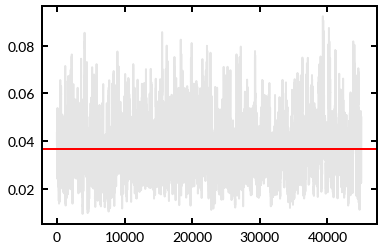

In [48]:
plt.plot(np.arange(len(So)), So, color='k', alpha=0.1)
plt.axhline(np.median(So), color='r')

In [31]:
np.median(So)

0.03670475546166381

Text(0, 0.5, 'Flux [cnts/s]')

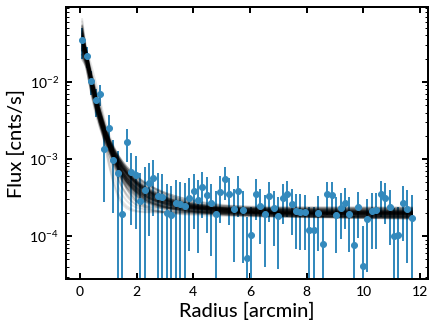

In [35]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6.5, 5))
# data
ax.errorbar(x, d['sb'], yerr=d['sb_err'], fmt='o', label='data')
for So, rc, beta, bg in samples[np.random.randint(len(samples), size=100)]:
    ax.plot(x, beta_model(So, x, rc, beta) + bg, color='k', alpha=0.1)
ax.semilogy()

ax.set_xlabel('Radius [arcmin]')
ax.set_ylabel('Flux [cnts/s]')